# Import dataset

In [1]:
import pandas as pd
filename = 'creditcard.csv'
df = pd.read_csv(filename, header = 0)

# Explore the dataset

In [2]:
print(df.shape)

(284807, 31)


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Summarize the class distribution

In [4]:
from collections import Counter
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=284315, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%


There is a severe skew in the class distribution, with about 99.827% of transactions marked as normal and 0.173% marked as fraudulent.

## Create histograms of input variables

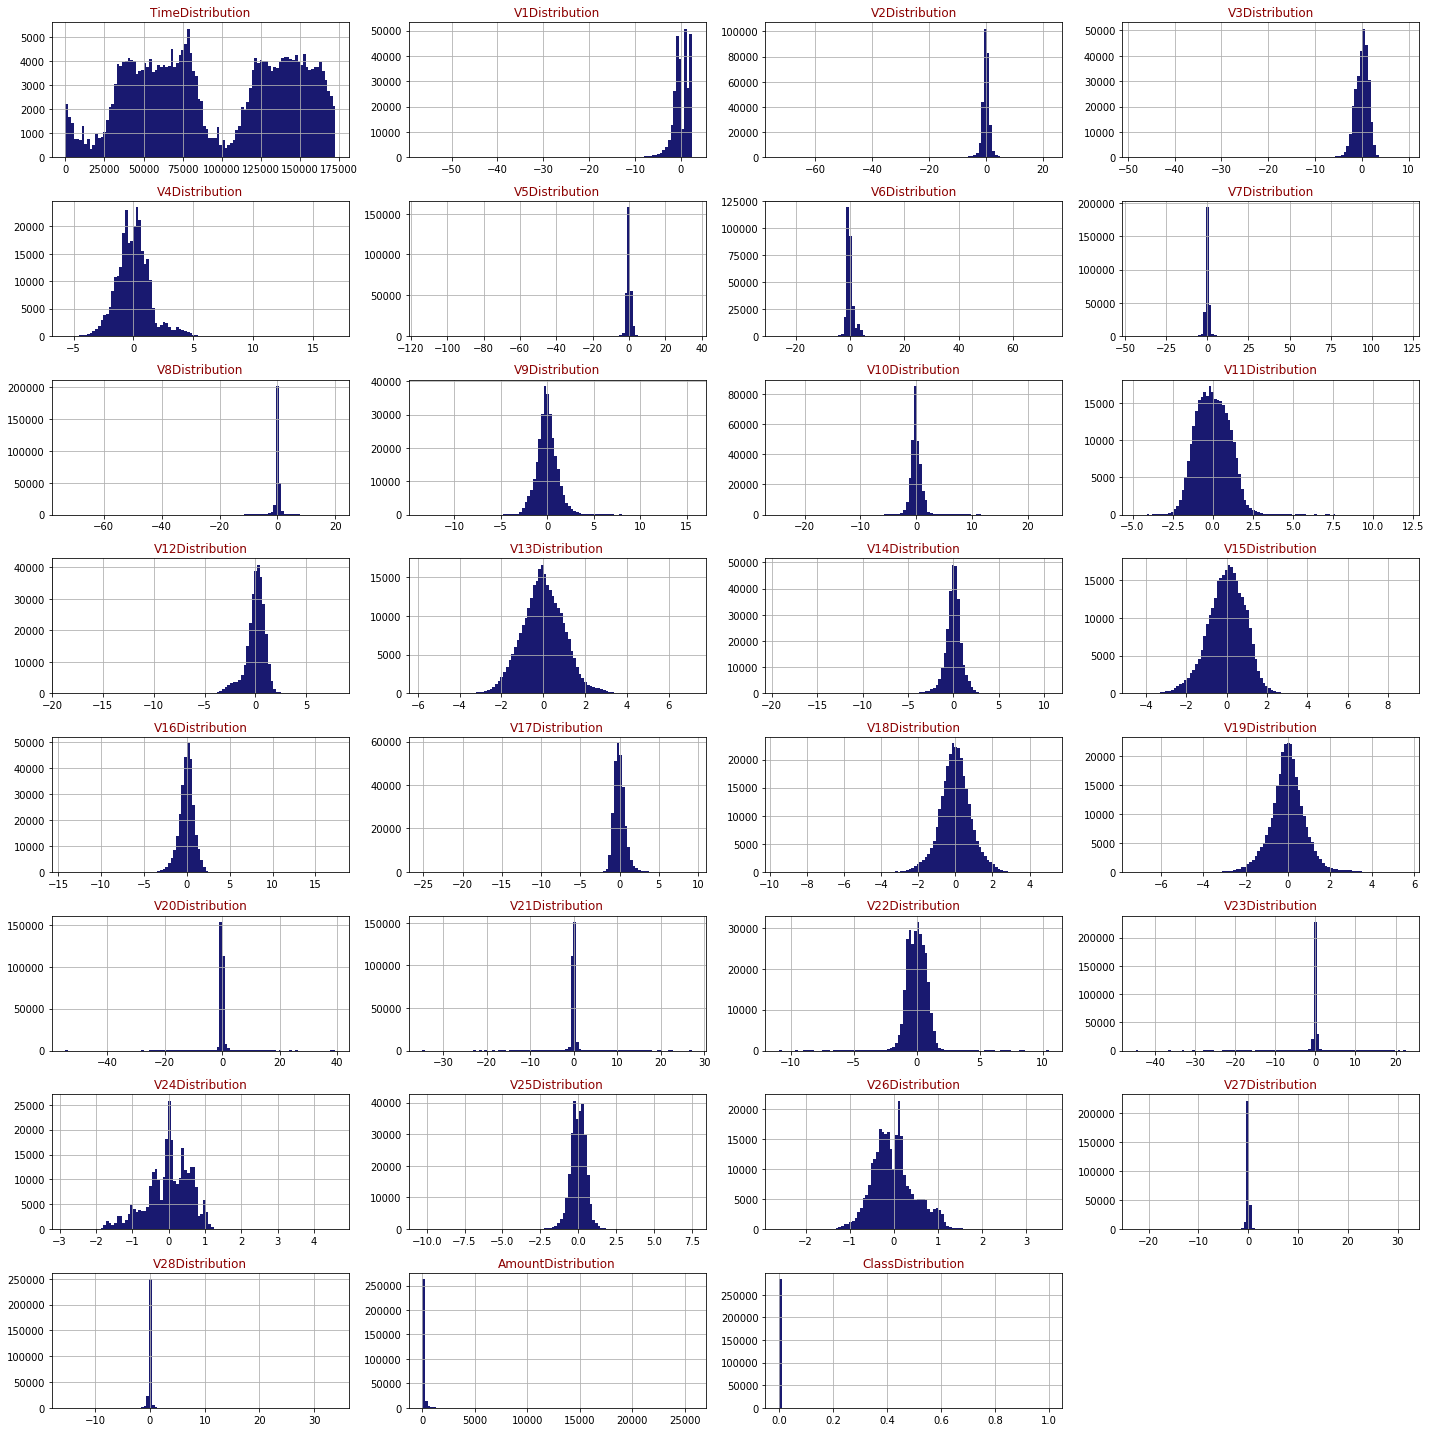

In [5]:
from matplotlib import pyplot as plt
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins = 100, ax = ax, facecolor = 'midnightblue')
        ax.set_title(feature + "Distribution", color = "DarkRed")
    fig.tight_layout()
    plt.show()

draw_histograms(df, df.columns, 8, 4)

* We can see that the distribution of most of the PCA components is Gaussian, and many may be centered around zero, suggesting the variables were standardized as part of the PCA transform.
* The amount values are highly skewed. Hence, we create a 5-number summary to get a better idea of transaction sizes. 

## Descriptive statistics of Amount column

In [6]:
print(df['Amount'].describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


* We observe that most amounts are small, with a mean of about 88, and the middle 50% of observations are between 5 and 77.
* The largest value is about 26,691, which is pulling the distribution up and might be an outlier (eg. someone purchased a car with their credit card).

Now that we have reviewed the dataset, let's look at developing a test harness for evaluating candidate models.

# Model Test and Baseline Result

## (1) Evaluation Strategy

### Repeated Stratified K-fold cross validation

We will use ***repeated stratified K-fold cross validation*** to evaluate candidate models. ***Stratified*** means that each fold will contain the same proportion of examples by class i.e. about 99.8% to 0.2% of normal and fraudulent cases, respectively. ***Repeated*** means the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model.

### Precision-Recall curve

We will use the metric of area under precision-recall curve or PR AUC, since there is such a severe class imbalance. 

$$
Precision = \frac{True Positives} {True Positives + False Positives}
$$

$$
Recall = \frac{True Positives} {True Positives + False Negatives}
$$

A precision-recall curve is a plot of the precision (y-axis) and the recall/sensitivity (x-axis) for different thresholds. The precision-recall curve is used when there is an imbalance in the observations between the two classes. The calculation of both precision and recall do not use True Negatives. It is only concerned with the correct prediction of the minority class (class 1). The reason for this is that typically a large number of class 0 examples means we are less interested in the skill of the model predicting Class 0 correctly i.e. True Negatives.

The metric requires that a given algorithm first predict a probability or probability-like measure. The predicted probabilities are then evaluated using precision and recall at a range of different thresholds for mapping probability to class labels, and the area under the curve of these thresholds is reported as the performance of the model.

### Define Functions

We will define the following functions to:
* Load the dataset and split the columns into input and output variables.
* Calculate the precision-recall curve for the predictions and calculate the area under the curve.
* Evaluate a given model on the dataset and return a list of PR AUC scores for each fold and repeat.

In [2]:
# Test harness and baseline model evaluation for the credit dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

# Load the dataset
def load_dataset(full_path):
    # Load the dataset as a numpy array
    data = read_csv(full_path, header = 0)
    # Retrieve numpy array
    data = data.values
    # Split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    return X, y

# Calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # Calculate precision-recall curve
    p, r, thresholds = precision_recall_curve(y_true, probas_pred)
    # Calculate area under curve
    return auc(r, p)

# Evaluate a model
def evaluate_model(X, y, model):
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    # Define the model evaluation metric
    metric = make_scorer(pr_auc, needs_proba = True)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring = metric, cv=cv, n_jobs=-1)
    return scores

## (2) Evaluate Baseline Model

Finally, we evaluate a baseline model on the dataset using the test harness. The baseline model predicts a positive class (class 1) for all examples, and the baseline performance is obtained using the precision-recall area under curve metric.

In [3]:
full_path = 'C:/Users/16478/Desktop/ML Projects/Credit card fraud/creditcard.csv'
X, y = load_dataset(full_path)

# Summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# Define reference model
model = DummyClassifier(strategy = 'constant', constant = 1)

# Evaluate the model
scores = evaluate_model(X, y, model)

# Summarize the performance
print('Mean PR AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

(284807, 30) (284807,) Counter({0.0: 284315, 1.0: 492})
Mean PR AUC: 0.501 (0.000)


The baseline algorithm achieves a mean PR AUC of about 0.501. This score provides a lower limit on model skill - any model that achieves a mean PR AUC above 0.501 has skill, whereas models that achieve a score below this value do not have skill.

# Evaluate models

We will evaluate a suite of different techniques on the dataset using the test harness developed in the previous section:
* Decision Tree (CART)
* k-Nearest Neighbors (KNN)
* Random Forest (RF)
* Extra Trees (ET)

Default model hyperparametrs are used, with the exception of the number of trees in the ensemble algorithms, which is set to a reasonable deafult of 100. Hence, the reported performance is good but not highly optimized. 

Since there is a difference in scale between the PCA variables and the dollar amount column, ***input variables are standardized prior to using them as input in the KNN algorithm***, as the KNN algorithm is sensitive to the scale of input variables.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

All algorithms are evaluated using the evaluation strategy outlined above, and the mean PR AUC and standard deviation of PR AUC scores are listed after evaluation is performed.

## (1) Decision Tree (CART)

In [11]:
model1 = DecisionTreeClassifier()
scores1 = evaluate_model(X, y, model1)
print('CART', mean(scores1), std(scores1))

CART 0.759066793548849 0.04413701203059241


## (2) k-Nearest Neighbors (KNN)

In [6]:
steps = [('s', StandardScaler()), ('m', KNeighborsClassifier())]
model2 = Pipeline(steps = steps)
scores2 = evaluate_model(X, y, model2)
print('KNN', mean(scores2), std(scores2))

KNN 0.8691429530865722 0.04197585403436753


## (3) Random Forest Classifier (RF)

In [5]:
model3 = RandomForestClassifier(n_estimators = 100)
scores4 = evaluate_model(X, y, model3)
print('RF', mean(scores3), std(scores3))

RF 0.8550635848388541 0.047744433650017605


## (4) Extra Trees Classifier (ET)

In [9]:
model4 = ExtraTreesClassifier(n_estimators = 100)
scores5 = evaluate_model(X, y, model4)
print('ET', mean(scores4), std(scores4))

ET 0.8644670621968569 0.04558469973266225


All tested algorithms have skill, achieving a mean PR AUC of above the baseline 0.501. Theresults suggest that the ensembles of decision tree algorithms all do well on this dataset, although the KNN with standardization of the dataset performs the best on average. The KNN score also has the least standard deviation, suggesting a tight distribution and that the scores are probably quite stable.

## Find optimum n_neighbors for KNN model

In [8]:
knn_scores = []
for k in range(1,7):
    steps = [('s', StandardScaler()), ('m', KNeighborsClassifier(n_neighbors = k))]
    model = Pipeline(steps = steps)
    scores = evaluate_model(X, y, model)
    print(k, mean(scores))
    knn_scores.append(mean(scores))

1 0.8491565024795935
2 0.8742314476390673
3 0.873159968441911
4 0.8704597220593783
5 0.8691429530865722
6 0.8664292240698191


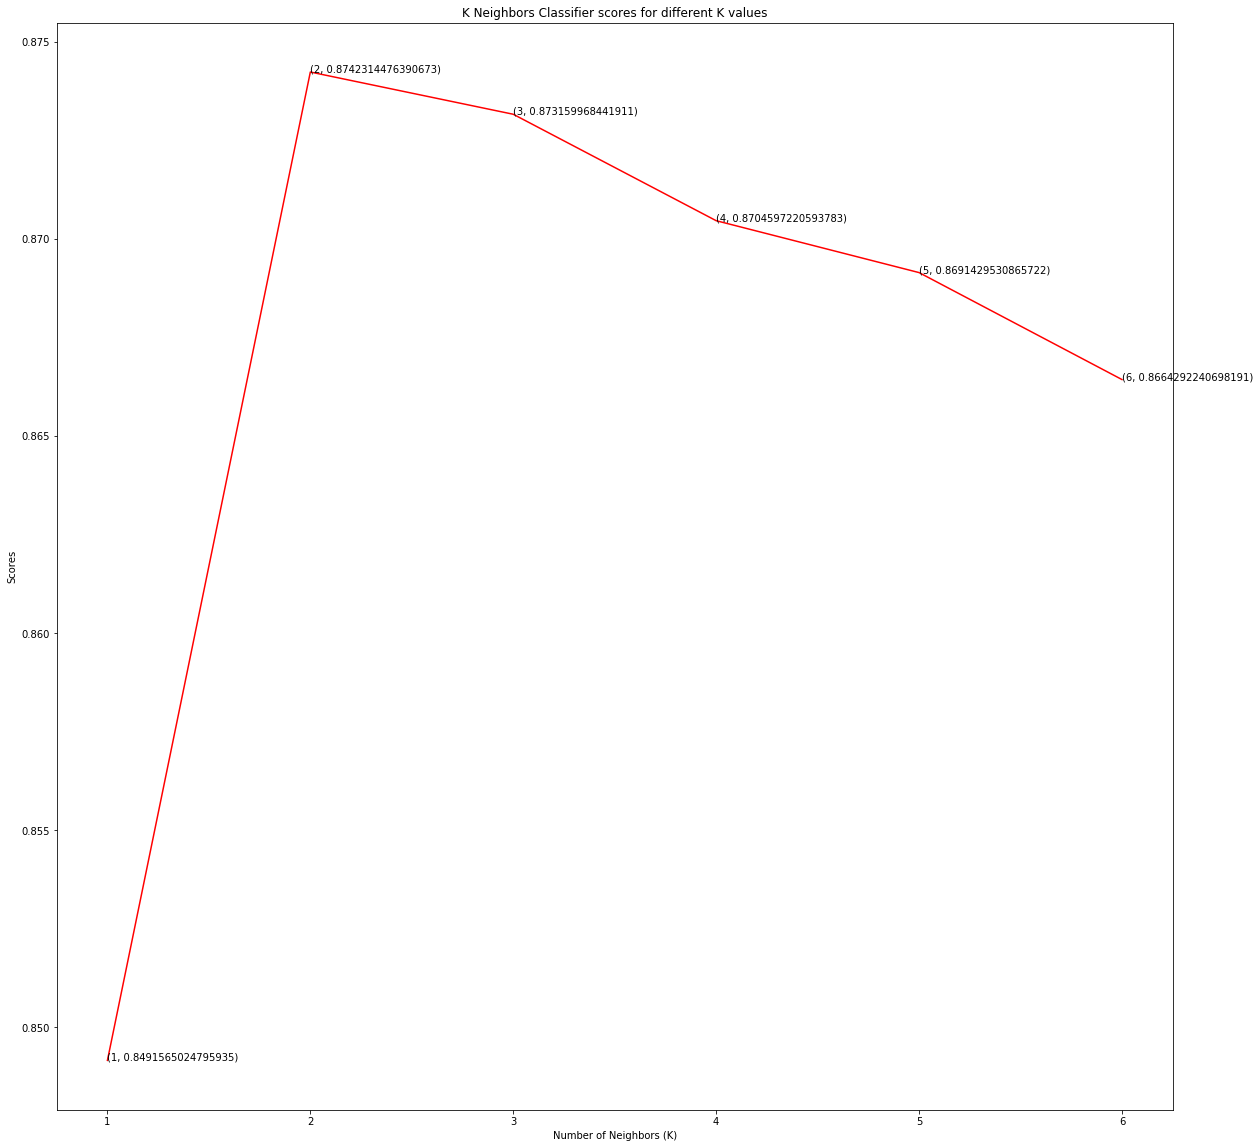

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,20))
plt.plot([k for k in range(1, 7)], knn_scores, color = 'red')
for i in range(1, 7):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
plt.xticks([i for i in range(1, 7)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')
plt.show()

'k' = 2 produces the highest score. However, for prediction purposes, we take the KNN classifier with 'k' = 3 to break the tie since the KNN classifier with 'k' = 3 still has a higher score than the default model with 'k' = 5

# Make prediction on new data using the KNN model

In [16]:
model = KNeighborsClassifier(n_neighbors = 3)
pipeline = Pipeline(steps = [('s', StandardScaler()), ('m', model)])
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('s', StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('m',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)

The fit model is used to predict the label of normal cases and fraud cases chosen from the dataset file.

### Evaluate on some normal cases (Class 0)

In [17]:
print('Normal cases:')
data = [[0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62],
	[0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69],
	[1,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459424895,0.066083685268831,0.717292731410831,-0.165945922763554,2.34586494901581,-2.89008319444231,1.10996937869599,-0.121359313195888,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.909412262347719,-0.689280956490685,-0.327641833735251,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66]]
for row in data:
    # Make prediction
    yhat = pipeline.predict_proba([row])
    # Get the probability for the positive class
    result = yhat[0][1]
    # Summarize
    print('>Predicted=%.3f (expected 0)' % (result))

Normal cases:
>Predicted=0.000 (expected 0)
>Predicted=0.000 (expected 0)
>Predicted=0.000 (expected 0)


### Evaluate on some fraud cases (Class 1)

In [18]:
print('Fraud cases:')
data = [[406,-2.3122265423263,1.95199201064158,-1.60985073229769,3.9979055875468,-0.522187864667764,-1.42654531920595,-2.53738730624579,1.39165724829804,-2.77008927719433,-2.77227214465915,3.20203320709635,-2.89990738849473,-0.595221881324605,-4.28925378244217,0.389724120274487,-1.14074717980657,-2.83005567450437,-0.0168224681808257,0.416955705037907,0.126910559061474,0.517232370861764,-0.0350493686052974,-0.465211076182388,0.320198198514526,0.0445191674731724,0.177839798284401,0.261145002567677,-0.143275874698919,0],
	[7519,1.23423504613468,3.0197404207034,-4.30459688479665,4.73279513041887,3.62420083055386,-1.35774566315358,1.71344498787235,-0.496358487073991,-1.28285782036322,-2.44746925511151,2.10134386504854,-4.6096283906446,1.46437762476188,-6.07933719308005,-0.339237372732577,2.58185095378146,6.73938438478335,3.04249317830411,-2.72185312222835,0.00906083639534526,-0.37906830709218,-0.704181032215427,-0.656804756348389,-1.63265295692929,1.48890144838237,0.566797273468934,-0.0100162234965625,0.146792734916988,1],
	[7526,0.00843036489558254,4.13783683497998,-6.24069657194744,6.6757321631344,0.768307024571449,-3.35305954788994,-1.63173467271809,0.15461244822474,-2.79589246446281,-6.18789062970647,5.66439470857116,-9.85448482287037,-0.306166658250084,-10.6911962118171,-0.638498192673322,-2.04197379107768,-1.12905587703585,0.116452521226364,-1.93466573889727,0.488378221134715,0.36451420978479,-0.608057133838703,-0.539527941820093,0.128939982991813,1.48848121006868,0.50796267782385,0.735821636119662,0.513573740679437,1]]

for row in data:
    # Make prediction
    yhat = pipeline.predict_proba([row])
    # Get the probability for the positive class
    result = yhat[0][1]
    # Summarize
    print('>Predicted=%.3f (expected 1)' % (result))

Fraud cases:
>Predicted=1.000 (expected 1)
>Predicted=0.333 (expected 1)
>Predicted=1.000 (expected 1)
